In [10]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rand
import NSMap as ns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
from datetime import datetime

# %matplotlib notebook
%load_ext autoreload
%autoreload 2

### Bring one Newport multiwindow and one Baltic Sea multiwindow analysis together into a figure

In [11]:
filename = "../datasets/baltic_sea_mesocosm_transformed.csv"

df = pd.read_csv(filename, encoding="utf-8", na_filter=False)
table = df.to_numpy()

In [12]:
def makeHeatMapBaltic(results):
    nonstationarityHeatMap = np.zeros((29,29)) * np.nan
    for l, o, d, t, r in results:
        i_length = 27-(int(l / year_steps) - 2)
        i_offset = int(o / year_steps)
        # print(i_length, i_offset)
        nonstationarityHeatMap[i_length, i_offset] = d
        
    return nonstationarityHeatMap

def makeFigureBaltic(nonstationarityHeatMap, ts, name, ax):
    scaling = lengths[-1] *3.35 / 365
    
    im = ax.imshow(np.log(nonstationarityHeatMap[:-2]+1), cmap=custom_cmap)
    ax.set_xticks(np.arange(31,step = 30 / scaling))
    ax.set_yticks(30-365*np.arange(1,8)/3.35/26) # DON'T TOUCH THIS LINE
    ax.set_xticklabels([])
    ax.set_yticklabels(np.arange(1,8))
    ax.set_ylim(27,-1)
    ax.set_xlim(-1.3,32)
    
    ax.set_ylabel("Time series length (years)",fontsize=15)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label(r"$\log(\overline{\delta}+1)$",fontsize=15)

    axTS = divider.append_axes('bottom', size='30%', pad=0.1)

    axTS.plot(table[:,0]/365, ts,c="dodgerblue")
    axTS.set_ylabel(name, fontsize = 15)
    axTS.set_xlabel("Start year",fontsize=15)
    axTS.set_yticks([])

    # plt.savefig(f"../Figures/baltic_sea_multiwindow_analysis/{name}_multiwindow.png", dpi=300)
    # plt.show()

In [13]:
def get_species_series(species_name, life_history_stage):
    
    species_df = data.query('GenusSpecies == ["{}"] and LifeHistoryStage == ["{}"]'.format(species_name, life_history_stage))
    species_dates = [(datetime.strptime(m, "%m/%d/%Y")).date() for m in species_df["SampleDate"].to_numpy()]
    species_abundances = species_df["Sum(Density (#/m3)"].to_numpy()
    
    ts = time_series_default.copy()
    
    for i in range(ts.shape[0]):
        month = months[i]
        valid_species = np.array([date.year == month.year and date.month == month.month for date in species_dates])
        
        if np.any(valid_species):
            abundance = np.mean(species_abundances[valid_species])
            ts[i] = abundance
        
    return ts

def get_species_aggregate_series(species_name):
    life_stages = pd.unique(data.query('GenusSpecies == ["{}"]'.format(species_name))["LifeHistoryStage"])
    
    time_series = np.zeros(312)
    for life_stage in life_stages:
        time_series += get_species_series(species_name, life_stage)
    
    return time_series

In [34]:
def makeHeatMapNewport(results):
    nonstationarityHeatMap = np.zeros((25,25)) * np.nan
    for l, o, d, t, r in results:
        i_length = 24-(int(l/12) - 2)
        i_offset = int(o/12)
        nonstationarityHeatMap[i_length, i_offset] = d
    
    return nonstationarityHeatMap

def makeFigureNewport(nonstationarityHeatMap, ts, name, ax):
    # fig, ax = plt.subplots(1,figsize=(13,10))
    # fig, ax = plt.subplots(1,figsize=(8,8))
    im = ax.imshow(np.log(nonstationarityHeatMap[:-3]+1), cmap=custom_cmap)
    ax.set_xticks(np.arange(0,26+1,step=2))
    ax.set_xlim(-1.08,27.7)

    ax.set_ylabel("Time series length (years)",fontsize=15)
    ax.set_yticks(np.arange(-1,22+1))
    ax.set_yticklabels(np.flip(np.hstack([np.arange(4,25+1)+1,""])))

    # drawBracket(2008, 9, ax)
    # drawBracket(2014, 8, ax)
    # drawBracket(1996, 26, ax)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label(r"$\log(\overline{\delta}+1)$",fontsize=15)

    axTS = divider.append_axes('bottom', size='30%', pad=0.1)

    axTS.plot(np.linspace(1996.264,2022.335,num=312), ts,c="dodgerblue")
    axTS.set_xticks(np.arange(1996,2022+1,step=2))
    axTS.set_yticks([])
    axTS.set_ylabel(f"{name}", fontsize = 15, style = "italic")
    axTS.set_xlabel("Start year",fontsize=15)

    # plt.savefig(f"../Figures/newport_multiwindow_analysis/{name}_multiwindow.png", dpi=300)

In [35]:
orange_rgba = colors.to_rgba("orange")
dodgerblue_rgba = colors.to_rgba("dodgerblue")
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [dodgerblue_rgba, orange_rgba]) 
# ListedColormap(np.array([dodgerblue_rgba, orange_rgba]))

In [36]:
filename = "../datasets/newport/Copepod_Cladoceran_Oikopleura_densities_NH05_1996-present.csv"
data = pd.read_csv(filename, encoding="utf-8")

In [37]:
# first we construct the t time series since it is identical for all species
dates = [(datetime.strptime(m, "%m/%d/%Y")).date() for m in data["SampleDate"].unique()]
months = [m.date() for m in pd.date_range("1996-5-1","2022-4-1", freq='MS')]

# Must create a null time series which is 0 during all months
# where there was at least one observation and NULL otherwise
time_series_default = np.array([0 if np.any([date.year == month.year and date.month == month.month for date in dates])
                         else np.nan 
                         for month in months])

n_years = (months[-1] - months[0]).days / 365
t = np.linspace(0,1,num=len(months))

In [38]:
all_genus_species = data["GenusSpecies"].drop_duplicates()
species_dict = dict()
species_agg_dict = dict()

for gs in all_genus_species:
    ts = get_species_aggregate_series(gs)
    total = np.sum(ts, where = ~np.isnan(ts))
    
    species_dict[total] = (gs, ts)
    species_agg_dict[gs] = ts
    
species_time_series_sorted = [species_dict[x] for x in sorted(species_dict, reverse = True)]
species_ordered_by_abundance = [x[0] for x in species_time_series_sorted]

# species_ordered_by_abundance contains the species names in decreasing order of abundance 
# species_agg_dict maps the species name to the time series of every life stage aggregated together

In [39]:
#### Pseudocalanus

index = 0
species = species_ordered_by_abundance[:4][index]
species_label = ['Pseudocalanus', 'Oikopleura', 'Acartia Longiremis', 'Paracalanus Parvus']

ts = ns.standardize(np.sqrt(get_species_aggregate_series(species)))

In [40]:
def drawBracket(start_year, length, ax):
    start_index = start_year - 1996
    length_index = 26 - length
    ax.plot(np.array([start_index, start_index + length ]),
            np.ones(2)*length_index, c="black")

In [41]:
maxLen = ts.shape[0]
lengths = np.arange(24,maxLen+1,step=12)

In [42]:
results = np.loadtxt(f"../results/newport_multiwindow/{species}_time_window.csv", delimiter=",")

In [43]:
def NewportGett():
    # first we construct the t time series since it is identical for all species
    dates = [(datetime.strptime(m, "%m/%d/%Y")).date() for m in data["SampleDate"].unique()]
    months = [m.date() for m in pd.date_range("1996-5-1","2022-4-1", freq='MS')]

    # Must create a null time series which is 0 during all months
    # where there was at least one observation and NULL otherwise
    time_series_default = np.array([0 if np.any([date.year == month.year and date.month == month.month for date in dates])
                             else np.nan 
                             for month in months])

    n_years = (months[-1] - months[0]).days / 365
    t = np.linspace(0,1,num=len(months))

0.92332


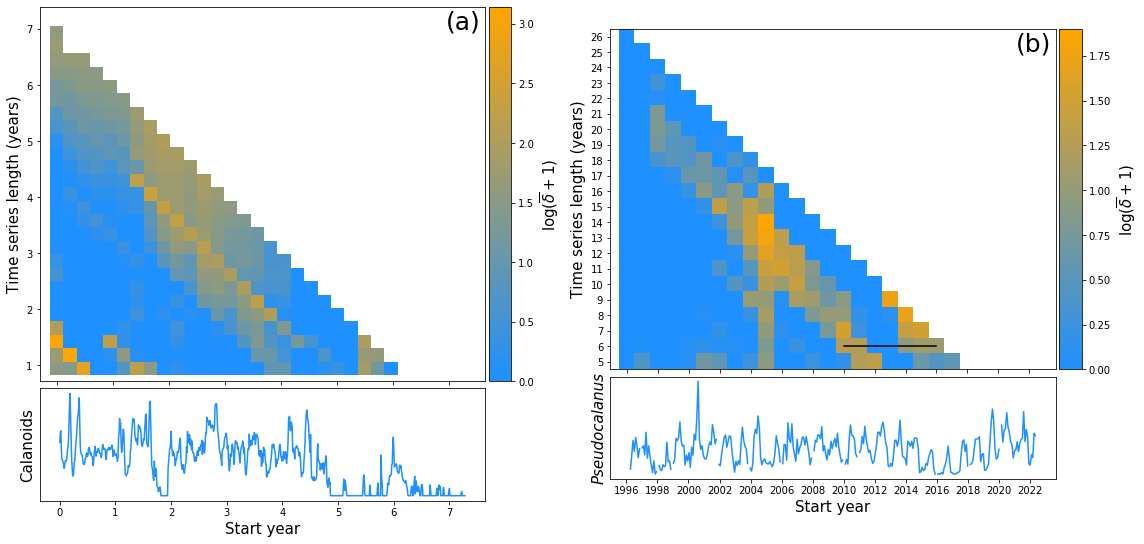

In [44]:
text_padding = 0.01 # -0.075

# Newport
filename = "../datasets/baltic_sea_mesocosm_transformed.csv"

df = pd.read_csv(filename, encoding="utf-8", na_filter=False)
table = df.to_numpy()

fig, ax = plt.subplots(1, 2, figsize=(16,8))

index = 0
year_steps = 27

species_baltic = "Calanoids"
results = np.loadtxt(f"../results/baltic_sea_multiwindow/{species_baltic}_time_window.csv",
                     delimiter=",")
lengths = np.unique(results[:,0])

print(results[-1,4])

ts = ns.standardize(table[:,index+1])
nonstationarityHeatMap = makeHeatMapBaltic(results)
makeFigureBaltic(nonstationarityHeatMap, ts, species_baltic, ax[0])

# Pseudocalanus
species_newport = 'PSEUDOCALANUS'
ts = ns.standardize(np.sqrt(get_species_aggregate_series(species_newport)))
results = np.loadtxt("../results/newport_multiwindow/pseudocalanus_time_window.csv", delimiter=",")

# first we construct the t time series since it is identical for all species
dates = [(datetime.strptime(m, "%m/%d/%Y")).date() for m in data["SampleDate"].unique()]
months = [m.date() for m in pd.date_range("1996-5-1","2022-4-1", freq='MS')]

# Must create a null time series which is 0 during all months
# where there was at least one observation and NULL otherwise
time_series_default = np.array([0 if np.any([date.year == month.year and date.month == month.month for date in dates])
                         else np.nan 
                         for month in months])

n_years = (months[-1] - months[0]).days / 365
t = np.linspace(0,1,num=len(months))

nonstationarityHeatMap = makeHeatMapNewport(results)
makeFigureNewport(nonstationarityHeatMap, ts, "Pseudocalanus", ax[1])

ax[0].text(1 - text_padding, 1 - text_padding, "(a)", size=25, rotation=0, 
            horizontalalignment="right", verticalalignment="top",
            transform=ax[0].transAxes)
ax[1].text(1 - text_padding, 1 - text_padding, "(b)", size=25, rotation=0, 
            horizontalalignment="right", verticalalignment="top",
            transform=ax[1].transAxes)

drawBracket(2010, 6, ax[1])

plt.tight_layout()
plt.savefig("../PDF_figures_tables/Figure_5.pdf", format="pdf", bbox_inches="tight")